<a href="https://colab.research.google.com/github/kinjal30/Rock-Dataset_ML/blob/main/Rock_Database_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Is the Assignment 03 :
The First Step is to Load the dataset completely

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
zip_file_path = '/content/archive.zip'
extracted_dir = '/content/extracted/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [ ]:
# pip install --upgrade tensorflow


Data Is Made Available to perfrom Preprocessing and calculate  the required PCA Values to preserve 95% of data features.

In [ ]:
# pip install tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np
from sklearn.decomposition import PCA
from keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_images(directory, nPixels):
    X = []
    categories = []  # Keep track of categories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                img = load_img(os.path.join(subdir, file), target_size=(nPixels, nPixels))
                x = img_to_array(img)
                X.append(x.flatten())  # Flatten the image into a 1D array
                categories.append(file[0])  # Extract the category from the first letter of the filename
    X = np.stack(X)
    return X, categories


directory = "/content/drive/MyDrive/360 Rocks"
nPixels = 128

X_images ,categories = load_and_preprocess_images(directory, nPixels)
X_images

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_images)


In [ ]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_95_percent_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Print the result
print(f"Number of components needed to preserve 95% of the variance: {num_components_95_percent_variance}")

Number of components needed to preserve 95% of the variance: 228


In [ ]:
pca = PCA(n_components=num_components_95_percent_variance)
X_pca = pca.fit_transform(X_images)

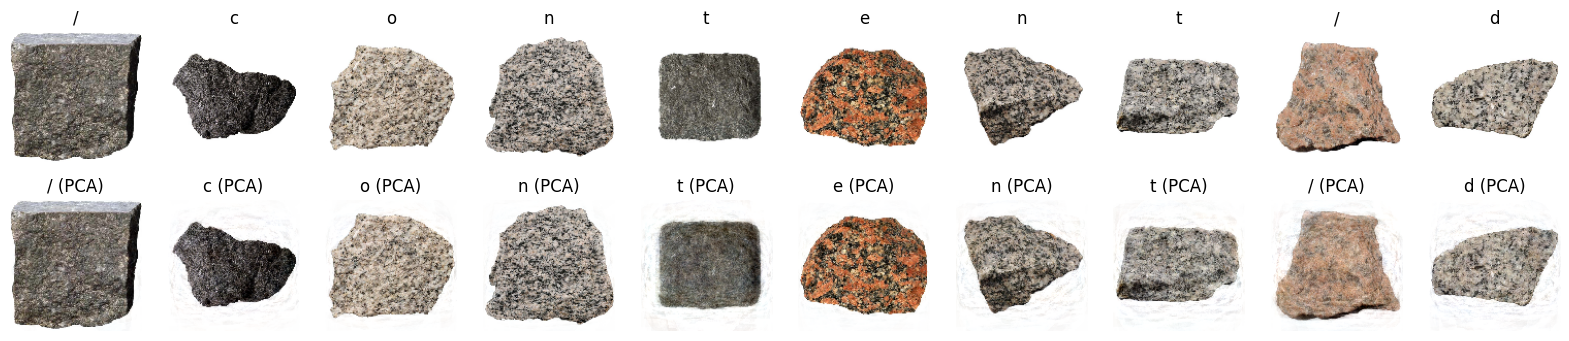

In [ ]:
import matplotlib.pyplot as plt
# Select the first 10 images for visualization
selected_images = X_images[:10, :]
selected_filenames = directory[:10]

# Visualize original images
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axes[0, i].imshow(selected_images[i].reshape(nPixels, nPixels, 3) / 255.0)
    axes[0, i].axis('off')
    axes[0, i].set_title(directory[i])

# Reconstruct images using PCA
X_reconstructed = pca.inverse_transform(X_pca[:, :num_components_95_percent_variance])

# Visualize reconstructed images
for i in range(10):
    axes[1, i].imshow(X_reconstructed[i].reshape(nPixels, nPixels, 3) / 255.0)
    axes[1, i].axis('off')
    axes[1, i].set_title(directory[i] + ' (PCA)')

plt.show()

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_images)

Variance explained by the first two principal components: 32.16%


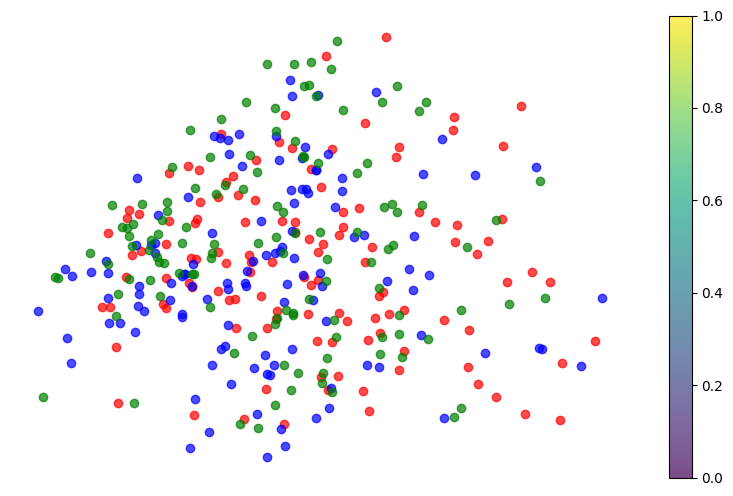

In [ ]:
variance_explained = np.sum(pca.explained_variance_ratio_)
print(f"Variance explained by the first two principal components: {variance_explained * 100:.2f}%")

# plt.figure(figsize=(13, 10))

# Visualize the data in 2D
colors = {'I': 'red', 'M': 'green', 'S': 'blue'}  # Assign colors to categories
plt.figure(figsize=(10, 6))

for category in set(categories):
    indices = [i for i, cat in enumerate(categories) if cat == category]
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=colors[category], label=category, alpha=0.7)

plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.pyplot as plt

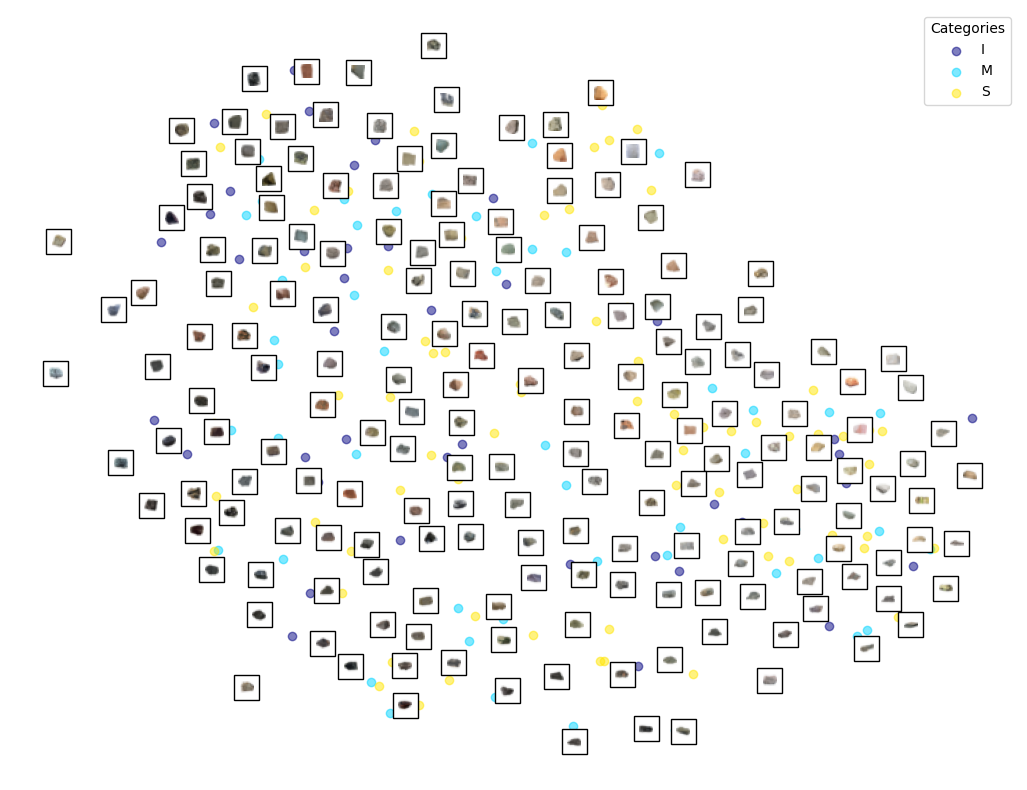

In [ ]:
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.pyplot as plt
import numpy as np

def plot_rocks(X, categories, min_distance=0.04, images=None, figsize=(13, 10), target_size=(50, 50)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the rocks plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    rock_categories = np.unique(categories)
    category_to_color = {cat: cmap(float(i) / len(rock_categories)) for i, cat in enumerate(rock_categories)}
    for category in rock_categories:
        indices = [i for i, cat in enumerate(categories) if cat == category]
        plt.scatter(X_normalized[indices, 0], X_normalized[indices, 1],
                    c=[category_to_color[category]], alpha=0.5, label=category)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], categories[index],
                         color=category_to_color[categories[index]],
                         fontdict={"weight": "bold", "size": 16})
            else:
                # Resize the image to fit the target size
                resized_image = resize(images[index].reshape(nPixels, nPixels, 3)/255.0, target_size)
                imagebox = AnnotationBbox(OffsetImage(resized_image, cmap="viridis"),
                                          image_coord)
                ax.add_artist(imagebox)

    plt.legend(loc='upper right', title='Categories')
    plt.show()

# Example usage:
# Assume X_rocks and rock_categories are your rock images and their corresponding categories
# You may need to adjust the parameters based on your data
# plot_rocks(X_rocks, rock_categories, images=X_images, figsize=(13, 10), target_size=(50, 50))
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_images)
plot_rocks(X_tsne, categories, images=X_images, figsize=(13, 10), target_size=(10, 10))


# t-SNE gives better visualization of data and it is often effective in preserving local structures and revealing clusters in high-dimensional data. It is particularly good at visualizing non-linear relationships.

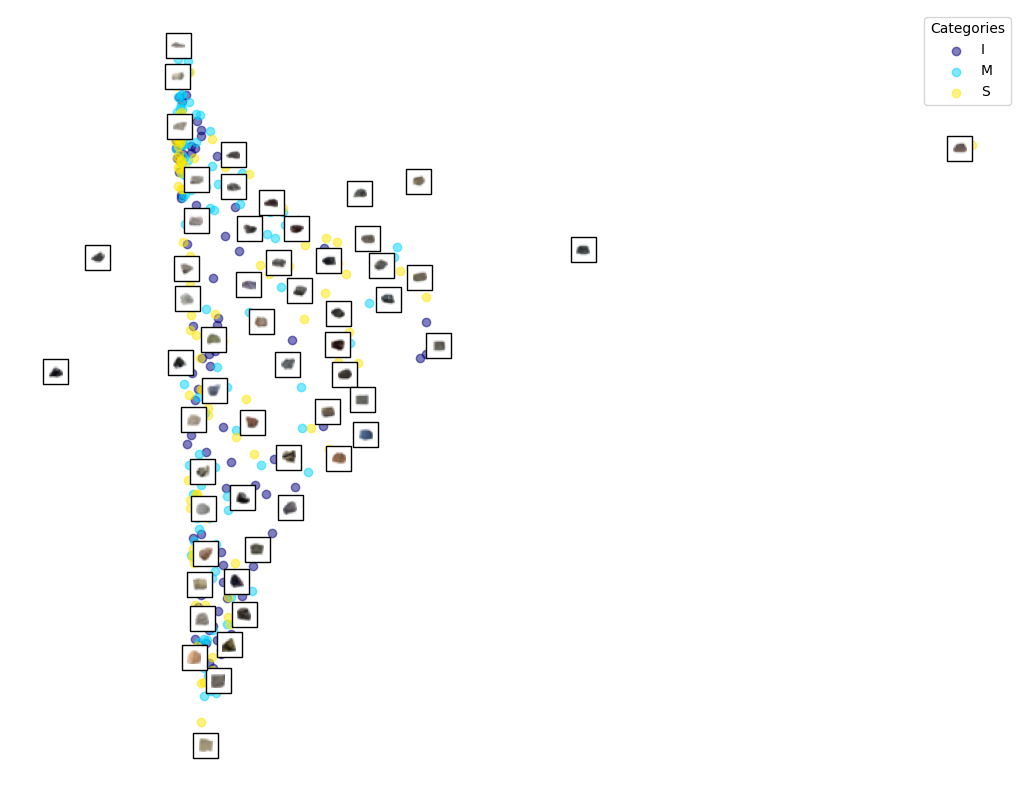

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# Use LocallyLinearEmbedding to reduce dimensionality
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_lle = lle.fit_transform(X_images)

# Plot rocks using LLE
plot_rocks(X_lle, categories, images=X_images, figsize=(13, 10), target_size=(10, 10))


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


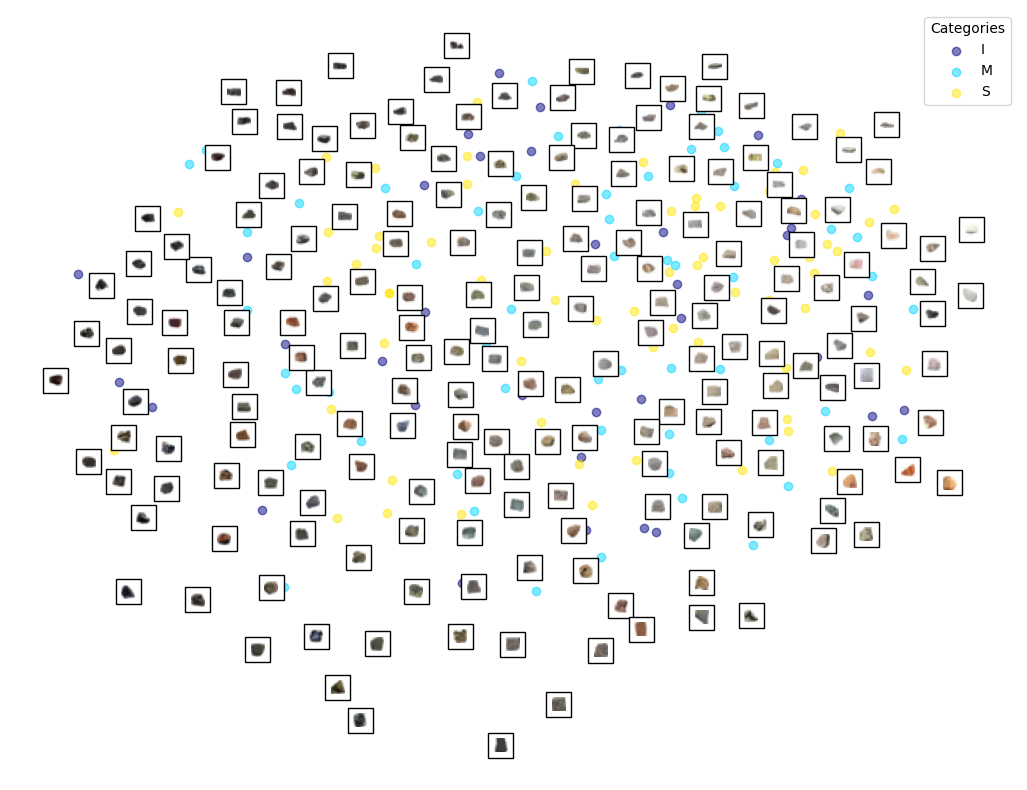

In [ ]:
from sklearn.manifold import MDS

# Use MDS to reduce dimensionality
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_images)

# Plot rocks using MDS
plot_rocks(X_mds, categories, images=X_images, figsize=(13, 10), target_size=(10, 10))


In [ ]:
# # Apply t-SNE to reduce dimensionality to 2 dimensions
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X_images)
# plot_images_on_other_methods(X_tsne, X_images, "t-SNE Visualization of Rock Categories")


# tsne = TSNE(n_components=2, init="random", learning_rate="auto",
#             random_state=42)
# %time X_reduced = tsne.fit_transform(X_sample)
# plt.figure(figsize=(13, 10))
# colors = {'I': 'red', 'M': 'green', 'S': 'blue'}  # Assign colors to categories


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# Apply LLE to reduce dimensionality to 2 dimensions using 'dense' solver
lle = LocallyLinearEmbedding(n_components=2, eigen_solver='dense')
X_lle = lle.fit_transform(X_images)
# plot_images_on_other_methods(X_lle, X_images, "Locally Linear Embedding (LLE) Visualization of Rock Categories")



# # Apply LLE to reduce dimensionality to 2 dimensions
# lle = LocallyLinearEmbedding(n_components=2)
# X_lle = lle.fit_transform(X_images)
# plot_images_on_other_methods(X_lle, X_images, "Locally Linear Embedding (LLE) Visualization of Rock Categories")

In [ ]:
# Apply MDS to reduce dimensionality to 2 dimensions
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X_images)
# plot_images_on_other_methods(X_mds, X_images, "Multidimensional Scaling (MDS) Visualization of Rock Categories")

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
import numpy as np
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS

# Load the human rankings from the mds_360.txt file
human_data = np.loadtxt('/content/drive/MyDrive/mds_360.txt')

# Define a function to perform dimensionality reduction and compare with Procrustes analysis
def compare_embeddings(embedding_method, embedding_name):
    # Perform dimensionality reduction
    embedding_result = embedding_method.fit_transform(X_images)

    # Ensure the shape is (360, 8)
    embedding_result = embedding_result[:, :8]

    # Perform Procrustes analysis
    mtx1, mtx2, disparity = procrustes(human_data, embedding_result)

    # Compute correlation coefficient for each dimension
    correlations = np.corrcoef(mtx1.T, mtx2.T)[:8, 8:]

    # Print results
    print(f"Results for {embedding_name}:")
    print(f"Disparity: {disparity}")
    print("Correlation Coefficients:")
    print(correlations)
    print("\n")

# PCA
pca = PCA(n_components=8)
compare_embeddings(pca, 'PCA')

# t-SNE
tsne = TSNE(n_components=8, method='exact', random_state=42)
compare_embeddings(tsne, 't-SNE')

# LLE
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=10, random_state=42)
compare_embeddings(lle, 'LLE')

# MDS
mds = MDS(n_components=8, random_state=42)
compare_embeddings(mds, 'MDS')


Results for PCA:
Disparity: 0.9861422029079396
Correlation Coefficients:
[[ 0.11139215 -0.03093333 -0.03321631  0.01464341 -0.00924968  0.02885381
  -0.01223575 -0.02519241]
 [-0.03619589  0.12087435 -0.00262573  0.00824524 -0.01132017 -0.04276106
   0.05956963  0.03017174]
 [-0.03458604 -0.00233651  0.14950695  0.00530256  0.03779479 -0.01384776
   0.03259883  0.03244809]
 [ 0.01313134  0.00631884  0.00456671  0.12177596  0.00466532  0.00167599
  -0.03258383 -0.01803709]
 [-0.00857495 -0.00896862  0.03365017  0.00482302  0.12406731 -0.00277301
   0.02232573  0.08855454]
 [ 0.0409519  -0.05186648 -0.01887561  0.00265262 -0.00424539  0.05929268
  -0.03904064 -0.00698683]
 [-0.01732768  0.07209447  0.04433658 -0.05145705  0.0341044  -0.03895432
   0.18226403  0.01706436]
 [-0.02727515  0.02791677  0.03373937 -0.02177695  0.10341971 -0.00532975
   0.01304601  0.15291977]]


Results for t-SNE:
Disparity: 0.9875221168758368
Correlation Coefficients:
[[ 1.54147438e-01  2.13857774e-03 -3.7334

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Results for MDS:
Disparity: 0.9820168636363245
Correlation Coefficients:
[[ 0.13305739 -0.02857498 -0.00060563 -0.01007047 -0.00585159  0.03166693
   0.00178423 -0.02442043]
 [-0.03346117  0.12037236  0.02235613  0.00034367 -0.01328701 -0.03746384
   0.03129022  0.0223748 ]
 [-0.00074248  0.02340545  0.17871368 -0.01728968  0.01817359 -0.01709397
   0.00826754  0.01510451]
 [-0.01092921  0.00031851 -0.0153056   0.12853618  0.00451513  0.01279707
  -0.01901475 -0.00032349]
 [-0.00674475 -0.01307869  0.01708667  0.00479538  0.18916793 -0.00362807
   0.00802226  0.06488135]
 [ 0.04154355 -0.04197153 -0.01829216  0.01546925 -0.00412935  0.07056725
  -0.02416847  0.00681311]
 [ 0.00271912  0.04072215  0.01027728 -0.02670109  0.01060673 -0.02807559
   0.18499351  0.02013858]
 [-0.03318759  0.02596727  0.01674378 -0.00040509  0.07649798  0.00705781
   0.01795866  0.12997975]]




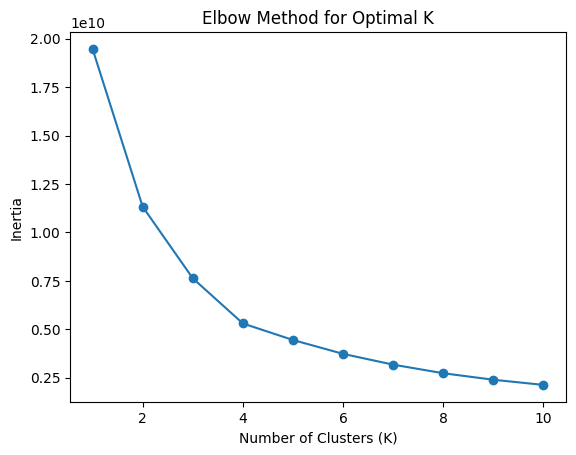

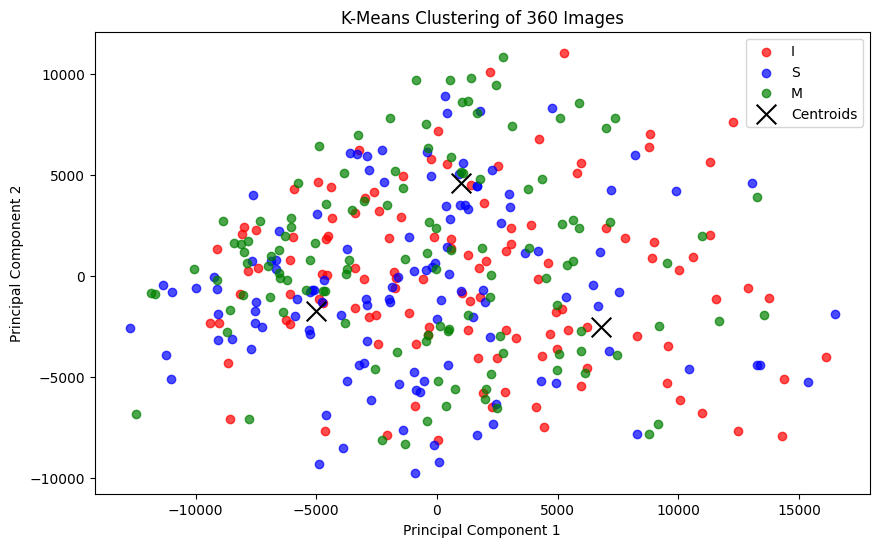

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_images)

# Determine the number of clusters using the Elbow method
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow curve, choose the optimal number of clusters
optimal_k = 3  # Adjust this based on the Elbow curve

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Visualize the clusters
plt.figure(figsize=(10, 6))
colors = {'I': 'red', 'M': 'green', 'S': 'blue'}
for category in set(categories):
    indices = [i for i, cat in enumerate(categories) if cat == category]
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=colors[category], label=category, alpha=0.7)

# Plot cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, c='black', label='Centroids')

plt.title('K-Means Clustering of 360 Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


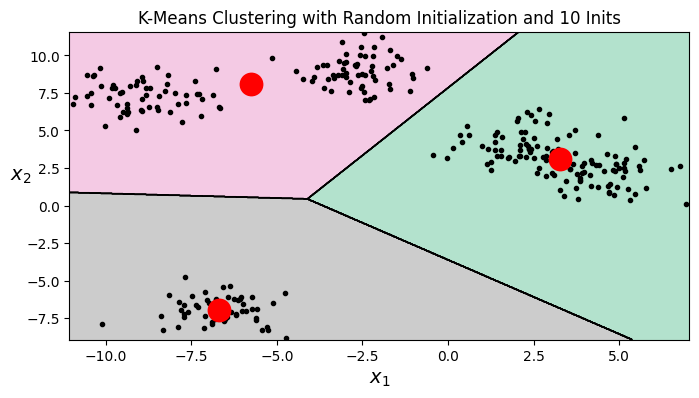

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Create a synthetic dataset for demonstration purposes
X, y = make_blobs(n_samples=300, centers=5, random_state=42)

# Define the plot_decision_boundaries function (assuming you have it)
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], c='k', marker='.')

    if show_centroids:
        centroids = clusterer.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='o', s=200, linewidths=3,
                    color='r', zorder=10)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# K-Means with random initialization and 10 inits
kmeans_rnd_10_inits = KMeans(n_clusters=3, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

# Visualize the decision boundaries
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.title("K-Means Clustering with Random Initialization and 10 Inits")
plt.show()


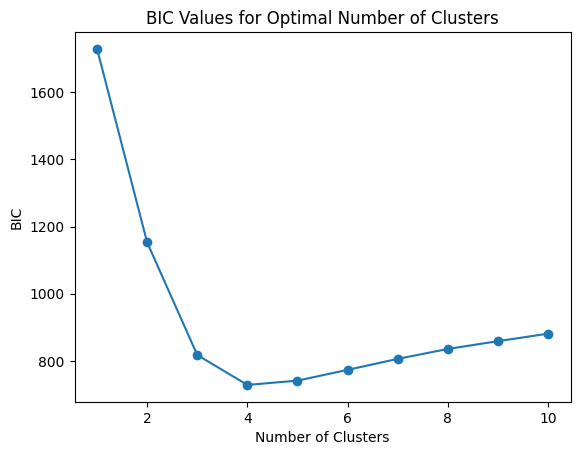

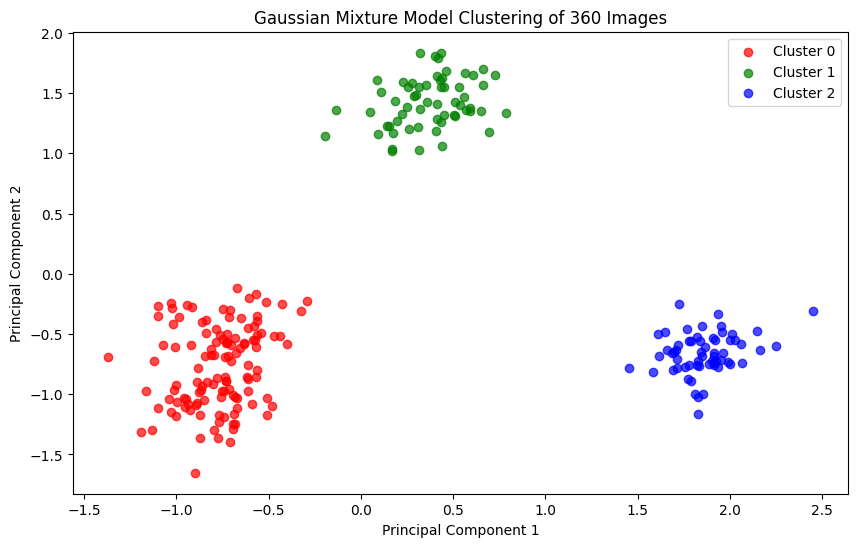

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Load and preprocess images (assuming you have the load_and_preprocess_images function)
def load_and_preprocess_images(directory, nPixels):
    # ... (same as in the previous code)
    return X, categories

directory = "/content/drive/MyDrive/360 Rocks"  # Change this to your directory
nPixels = 128

X_images, image_labels = load_and_preprocess_images(directory, nPixels)

# Reduce dimensionality using PCA
scaler = StandardScaler()
X_images_scaled = scaler.fit_transform(X_images)  # Standardize the features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_images_scaled)

# Determine the number of clusters using the Bayesian Information Criterion (BIC)
bic_values = []
for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca)
    bic_values.append(gmm.bic(X_pca))

# Plot the BIC values
plt.plot(range(1, 11), bic_values, marker='o')
plt.title('BIC Values for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()

# Choose the optimal number of clusters based on the lowest BIC
optimal_components = np.argmin(bic_values) + 1  # Add 1 to convert from zero-based indexing

# Perform Gaussian Mixture Model clustering with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
cluster_labels = gmm.fit_predict(X_pca)

# Define colors for each cluster label
colors = {0: 'red', 1: 'green', 2: 'blue'}  # Add more colors if needed

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_label in set(cluster_labels):
    # Skip the 4th cluster
    if cluster_label == 3:
        continue

    indices = [i for i, label in enumerate(cluster_labels) if label == cluster_label]
    plt.scatter(
        X_pca[indices, 0],
        X_pca[indices, 1],
        c=colors.get(cluster_label),  # Use color from the dictionary
        label=f'Cluster {cluster_label}',
        alpha=0.7
    )

plt.title('Gaussian Mixture Model Clustering of 360 Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Here to determine the optimal number of clusters, we observe the plot of BIC values and choose the "elbow" point, where the rate of decrease in BIC slows down. This point often indicates a reasonable trade-off between model complexity and goodness of fit.

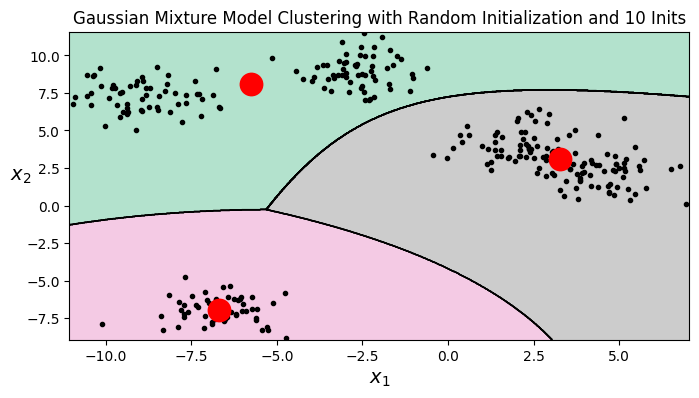

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

# Create a synthetic dataset for demonstration purposes
X, y = make_blobs(n_samples=300, centers=5, random_state=42)

# Define the plot_decision_boundaries function (assuming you have it)
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], c='k', marker='.')

    if show_centroids:
        centroids = clusterer.means_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='o', s=200, linewidths=3,
                    color='r', zorder=10)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Gaussian Mixture Model (EM) with random initialization and 10 inits
gmm_rnd_10_inits = GaussianMixture(n_components=3, init_params='random', n_init=10,
                                   random_state=2)
gmm_rnd_10_inits.fit(X)

# Visualize the decision boundaries
plt.figure(figsize=(8, 4))
plot_decision_boundaries(gmm_rnd_10_inits, X)
plt.title("Gaussian Mixture Model Clustering with Random Initialization and 10 Inits")
plt.show()


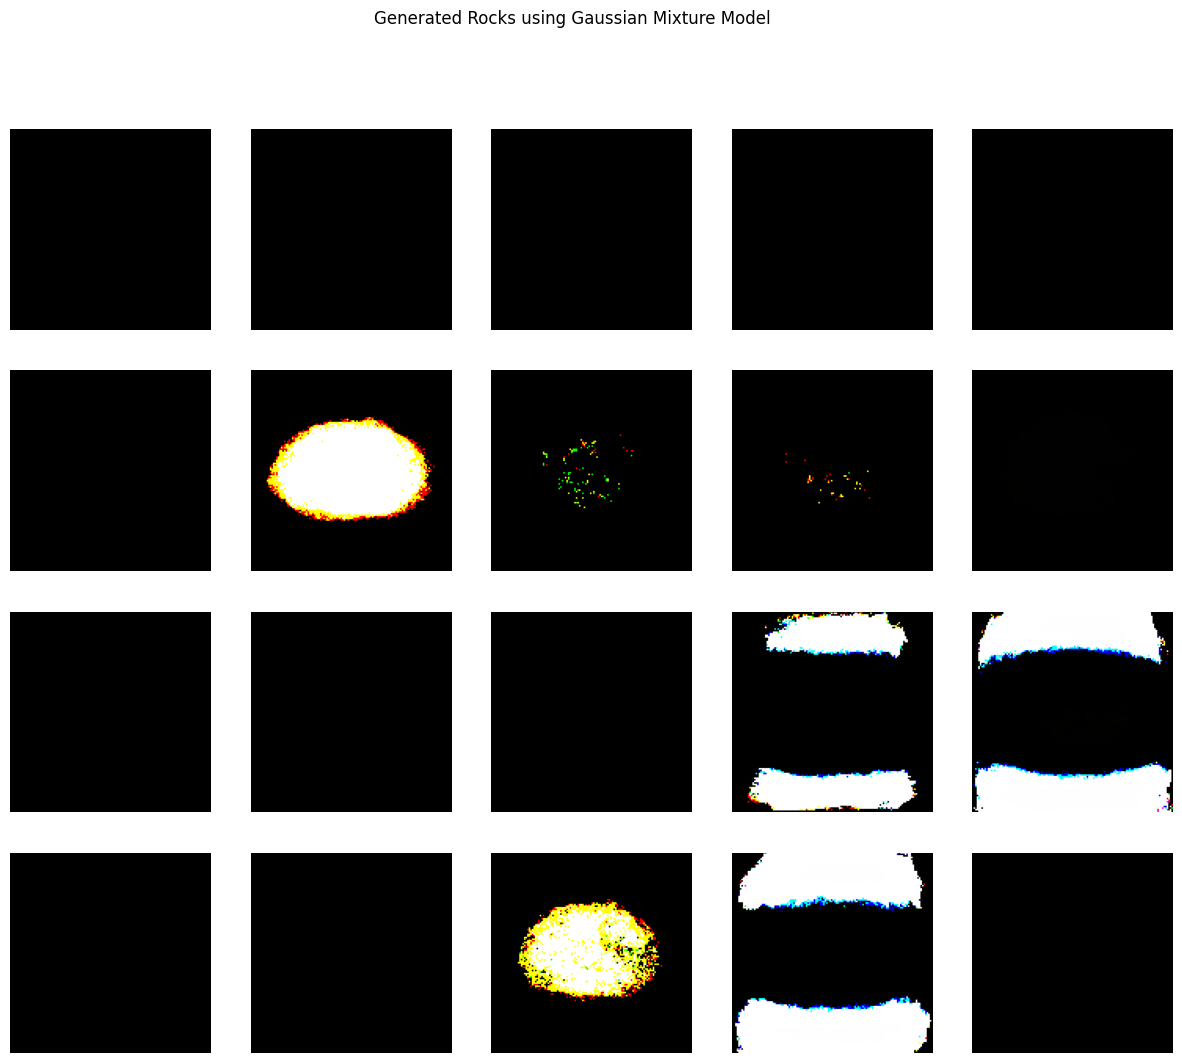

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import load_img, img_to_array
import os

# Load and preprocess images (assuming you have the load_and_preprocess_images function)
def load_and_preprocess_images(directory, nPixels):
    X = []
    categories = []  # Keep track of categories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                img = load_img(os.path.join(subdir, file), target_size=(nPixels, nPixels))
                x = img_to_array(img)
                X.append(x.flatten())  # Flatten the image into a 1D array
                categories.append(file[0])  # Extract the category from the first letter of the filename
    X = np.stack(X)
    return X, categories

directory = "/content/drive/MyDrive/360 Rocks"
nPixels = 128

X_images, categories = load_and_preprocess_images(directory, nPixels)

# Reduce dimensionality using PCA
scaler = StandardScaler()
X_images_scaled = scaler.fit_transform(X_images)  # Standardize the features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_images_scaled)

# Fit Gaussian Mixture Model
n_components = 3  # You can adjust this based on your desired number of clusters
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_pca)

# Sample from the GMM
generated_samples = gmm.sample(20)
generated_samples_transformed = generated_samples[0]

# Inverse transform to the original image space
generated_images = pca.inverse_transform(generated_samples_transformed)

# Visualize generated rocks in the original image space
plt.figure(figsize=(15, 12))

for i in range(len(generated_images)):
    generated_image = generated_images[i].reshape(nPixels, nPixels, -1)  # Reshape to the original image shape
    plt.subplot(4, 5, i + 1)
    plt.imshow(generated_image.astype(np.uint8))  # Convert to uint8 for proper display
    plt.axis('off')

plt.suptitle('Generated Rocks using Gaussian Mixture Model')
plt.show()


In [ ]:
train_dir = '/content/drive/MyDrive/360 Rocks'
validation_dir = '/content/drive/MyDrive/120 Rocks'


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import time
# Load and preprocess images
def load_and_preprocess_images(directory, nPixels):
    X = []
    categories = []  # Keep track of categories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                img = load_img(os.path.join(subdir, file), target_size=(nPixels, nPixels))
                x = img_to_array(img)
                X.append(x / 255.0)  # Normalize pixel values to the range [0, 1]
                categories.append(file[0])  # Extract the category from the first letter of the filename
    X = np.stack(X)
    return X, categories

# Set the directory paths
train_directory = "/content/drive/MyDrive/360 Rocks"
validation_directory = "/content/drive/MyDrive/120 Rocks"

# Image dimensions
nPixels = 128

# Load and preprocess training images
X_train, y_train = load_and_preprocess_images(train_directory, nPixels)

# Load and preprocess validation images
X_val, y_val = load_and_preprocess_images(validation_directory, nPixels)

# Map string labels to numerical values
label_mapping = {'I': 0, 'M': 1, 'S': 2}
y_train = [label_mapping[label] for label in y_train]
y_val = [label_mapping[label] for label in y_val]

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

# Split the training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build the neural network
model = models.Sequential()
model.add(layers.Flatten(input_shape=(nPixels, nPixels, 3)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time} seconds")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6291584   
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 dense_9 (Dense)             (None, 3)                 27        
                                                                 
Total params: 6302211 (24.04 MB)
Trainable params: 630

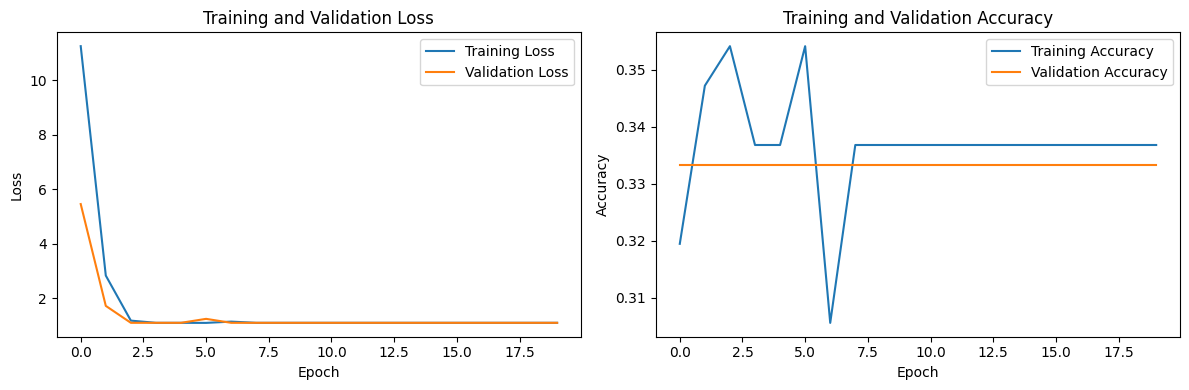

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Build the neural network
model = models.Sequential()
model.add(layers.Flatten(input_shape=(nPixels, nPixels, 3)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               6291584   
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 8)                 264       
                                                                 
 dense_14 (Dense)            (None, 3)                 27        
                                                                 
Total params: 6302211 (24.04 MB)
Trainable params: 630

# Here, the "Total params" line shows the total number of parameters, and the "Trainable params" line shows the number of trainable parameters. The difference between these two values represents the number of bias parameters, in this case bias parameters=0, since total and trainable parameters are the same

In [ ]:
import numpy as np
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
import pandas as pd

# Assuming you have trained the model and named it 'model'
# Extract activations for the second-to-last layer
layer_name = 'dense_2'  # Change this based on your model's architecture
intermediate_layer_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Function to get activations
def get_activations(generator, model):
    activations = []
    for i in range(generator.samples // batch_size + 1):
        batch = generator.next()
        activations.append(intermediate_layer_model.predict(batch[0]))
    return np.vstack(activations)

# Get activations for training and validation data
train_activations = get_activations(train_generator, intermediate_layer_model)
validation_activations = get_activations(validation_generator, intermediate_layer_model)

# Load human data
mds_360 = np.loadtxt('path/to/mds_360.txt')
mds_120 = np.loadtxt('path/to/mds_120.txt')

# Perform Procrustes analysis for training data
mtx1, mtx2, disparity = procrustes(train_activations, mds_360)

# Compute the correlation coefficient between each dimension
correlation_coefficients = [np.corrcoef(mtx1[:, i], mtx2[:, i])[0, 1] for i in range(mtx1.shape[1])]

# Display results in a table
result_table = pd.DataFrame({
    'Dimension': range(1, mtx1.shape[1] + 1),
    'Correlation Coefficient': correlation_coefficients
})

print("Procrustes Analysis Results - Training Data:")
print(result_table)

# Perform Procrustes analysis for validation data
mtx1_val, mtx2_val, disparity_val = procrustes(validation_activations, mds_120)

# Compute the correlation coefficient between each dimension for validation data
correlation_coefficients_val = [np.corrcoef(mtx1_val[:, i], mtx2_val[:, i])[0, 1] for i in range(mtx1_val.shape[1])]

# Display results in a table for validation data
result_table_val = pd.DataFrame({
    'Dimension': range(1, mtx1_val.shape[1] + 1),
    'Correlation Coefficient': correlation_coefficients_val
})

print("\nProcrustes Analysis Results - Validation Data:")
print(result_table_val)
